In [1]:

import importlib
import modules
from collections import Counter
import numpy as np
import powerlaw
importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt

from modules import run_model_stochastic
import random


importlib.reload(modules)


<module 'modules' from '/Users/carokluin/Documents/CSM/ComplexSystems/Project_complexsystems/CSS-Group1/modules.py'>

We could plot the traffic density over time, see if it approaches the critical density like we would expect for Self-Organized Criticality

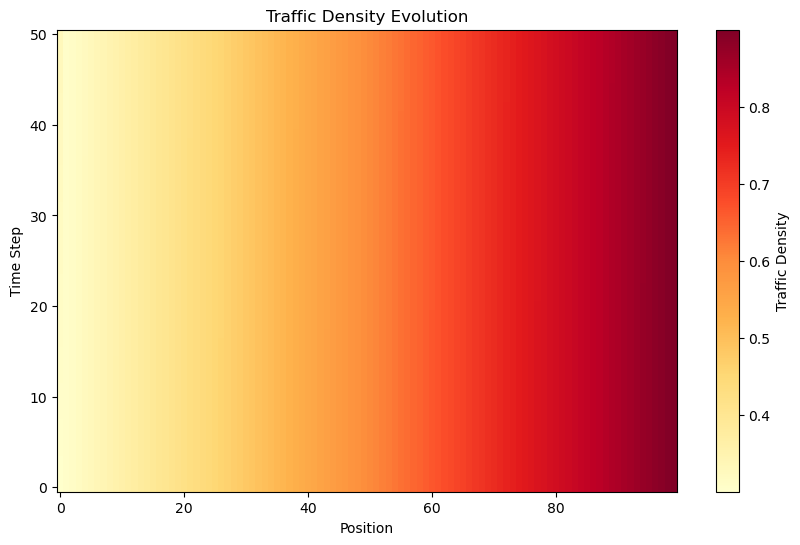

In [110]:
def plot_traffic_density(evolution):
    """
    Plot the traffic density heatmap for a given density evolution.

    Parameters:
    - evolution (numpy.ndarray): Traffic density evolution over time and space.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(evolution, cmap='YlOrRd', aspect='auto', origin='lower')
    plt.colorbar(label='Traffic Density')
    plt.xlabel('Position')
    plt.ylabel('Time Step')
    plt.title('Traffic Density Evolution')

    plt.show()


In [ ]:
#Fit power law curve: density as a function of the critical exponents
# Calculate mean and standard deviation of critical exponents
mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a curve to the mean critical exponents
def func(x, a, b):
    return a * x ** -b 

popt, pcov = curve_fit(func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

#Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

#Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

#plot the fitted curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', color='red', label=f'Fitted Curve: a={popt[0]:.2f}, b={popt[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()

Functions that analyze if the given data follows a powerlaw distribution.

In [24]:
#set up function to fit power law distribution
def analyze_powerlaw_distribution(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    (Only designed for heavy tailed distributions!)
    Makes use of the Kolmogorov-Smirnov test for which H0: data is power-law distributed, HA: data is not power-law distributed
    If H0 is rejected, the function will check if the data is exponentially distributed 
    If the function is not exponentially distributed, the function will return:
      "Not a power-law distribution (No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat, ks_p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    # Analyze the fit and return the result
    if ks_p_value < 0.05:
        # Reject the null hypothesis (data is unlikely to be power-law distributed)
        result = "Not a power-law distribution"

        # Check for alternative distribution (exponential)
        if fit.power_law.alpha is not None:
            result += f" (Exponential fit p-value: {ks_p_value:.4f})"
        else:
            result += " (No alternative distribution fit available)"
    else:
        # Accept the null hypothesis (data is likely to be power-law distributed)
        result = "Power-law distribution"

    return result



Example of how to use the function analyze_powerlaw_distribution

Calculating best minimal value for power law fit
Power-law distribution


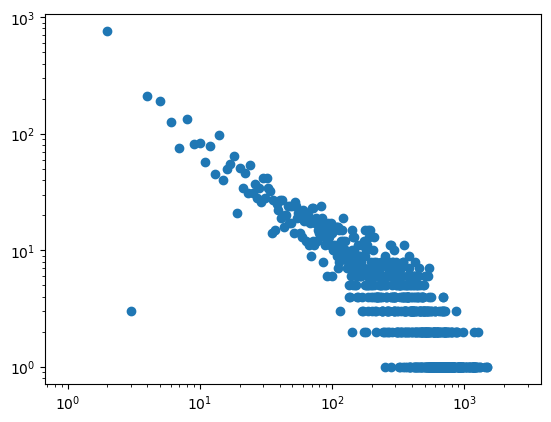

In [66]:

lifespan_count, jam_count = run_model_stochastic(p, L, T, n_repetitions, v_max, p_slowdown)

result_jam_test = analyze_powerlaw_distribution(list(jam_count.elements()))
print(result_jam_test)

#plt.hist(list(jam_size_counter.elements()), bins=100, density=True, label="Jam size distribution")
plt.loglog(range(1, int(max(jam_count.keys()))), [jam_count[i] for i in range(1, int(max(jam_count.keys())))], 'o')

Function that not only checks powerlaw versus exponential but also checks for bionomial, poisson and gamma 

In [47]:
#set up function to fit power law distribution and other distributions
def analyze_powerlaw_distribution2(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    
    Makes use of the Kolmogorov-Smirnov test for which H0: data is .. distributed, HA: data is not .. distributed
    If H0 is rejected for the power law distribution, the function will check if the data is exponentially,bionomial,gamma or poisson distributed 
    If the function is not matched with any of these distributions, the function will return:
      "No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True, verbose=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat_powerlaw, ks_p_value_powerlaw = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

#Check for power law distribution
    if ks_p_value_powerlaw < 0.05:
        result = "Not a power-law distribution"

        #Calculate p-values for alternative distributions
        ks_p_value_exponential = ks_2samp(data, np.random.exponential(np.mean(data), len(data)))[1]
        ks_p_value_poisson = ks_2samp(data, poisson.rvs(np.mean(data), size=len(data)))[1]
        ks_p_value_binomial = ks_2samp(data, np.random.binomial(n=int(np.mean(data)), p=0.5, size=len(data)))[1]
        ks_p_value_gamma = ks_2samp(data, gamma.rvs(np.mean(data)/2, scale=2, size=len(data)))[1]

        #Check alternative distributions, because we did 4 tests, we need to correct for multiple testing with bonferroni (0.05/4)
        if ks_p_value_exponential < 0.05/4:
            result += f" (Exponential fit p-value: {ks_p_value_exponential:.4f})"
        elif ks_p_value_poisson < 0.05/4:
            result += " (Poisson distribution)"
        elif ks_p_value_binomial < 0.05/4:
            result += " (Binomial distribution)"
        elif ks_p_value_gamma < 0.05/4:
            result += " (Gamma distribution)"
        else:
            result += " (No alternative distribution fit available)"

    else:
        result = "Power-law distribution"
